(sec:raman-tutorial)=
# Raman spectroscopy

The Raman scattering process involves the inelasic scattering of light in the visible range, leaving the molecule in a different vibrational state. The associated scattering amplitude is related to the transition polarizability tensor $\boldsymbol{\alpha}$, as discussed in more details [here](dipole_mom_gradient:label). In the case of normal Raman scattering described using the harmonic approximation for molecular vibrations, the transition polarizability associated to a normal mode $k$ depends on the derivative of the electronic polarizability with respect to the normal coordinate $Q_k$. As a consequence, only modes along which the polarizability changes will be Raman active.

## Raman spectra of H<sub>2</sub>O, NH<sub>3</sub> and CH<sub>4</sub>
Here, we will calculate the Raman spectra of H<sub>2</sub>O, NH<sub>3</sub> and CH<sub>4</sub> and determine how going from O over N to C influences the vibrational frequencies of the Hydrogen stretching modes.

In [1]:
# Import section
import veloxchem as vlx
import py3Dmol as p3d
import sys
from veloxchem.veloxchemlib import bohr_in_angstroms

from matplotlib import pyplot as plt
import numpy as np

basis_set_label = '6-31G'

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.
* Warning * Setting MKL_THREADING_LAYER to "GNU".


To compute a meaningful Raman spectrum, the molecular geometries must be optimized at the same level of theory and using the same basis set. Let us assume that we have optimized the geometries at the HF/6-31G theory level and we have these geometries stored in xyz files. Otherwise, we would start by performing the necessary geometry optimizations.

In [2]:
# Prepare molecules and basis sets:
h2o_xyz = open("../xyz/ir_raman/opt_h2o.xyz", "r").read() # read optimized geometry from file
nh3_xyz = open("../xyz/ir_raman/opt_nh3.xyz", "r").read() # read optimized geometry from file
ch4_xyz = open("../xyz/ir_raman/opt_ch4.xyz", "r").read() # read optimized geometry from file

h2o = vlx.Molecule.from_xyz_string(h2o_xyz)
h2o_basis = vlx.MolecularBasis.read(h2o, basis_set_label)

nh3 = vlx.Molecule.from_xyz_string(nh3_xyz)
nh3_basis = vlx.MolecularBasis.read(nh3, basis_set_label)

ch4 = vlx.Molecule.from_xyz_string(ch4_xyz)
ch4_basis = vlx.MolecularBasis.read(ch4, basis_set_label)

print("\n       (a) H2O                   (b) NH3                  (c) CH4")
viewer = p3d.view(viewergrid=(1,3),width=600,height=250, linked=True)
viewer.addModel(h2o_xyz, 'xyz', viewer=(0,0))
viewer.addModel(nh3_xyz, 'xyz', viewer=(0,1))
viewer.addModel(ch4_xyz, 'xyz', viewer=(0,2))
viewer.setStyle({'stick': {}})
viewer.show()


       (a) H2O                   (b) NH3                  (c) CH4


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

To compute the Raman spectrum, we need the vibrational frequencies and Raman intensities. The frequencies are eigenvalues of the molecular Hessian, while the Raman intensities are proportional to the gradient of the polarizability. The first step is to determine the Hessian matrix.

In [3]:
# Settings:
scf_settings = {'conv_thresh': 1.0e-5}
method_settings = {} # HF;  use 'xcfun': 'b3lyp', 'grid_level': 4, etc. for a DFT calculation 
# Numerical Hessian
hessian_settings = {'do_raman': 'yes', 'print_depolarization_ratio':'yes'}

# We first need to run SCF calculations:
h2o_scfdrv = vlx.ScfRestrictedDriver()
h2o_scfdrv.update_settings(scf_settings, method_settings)
h2o_scfdrv.ostream.state = False # To remove printout
h2o_scfdrv.compute(h2o, h2o_basis)

nh3_scfdrv = vlx.ScfRestrictedDriver()
nh3_scfdrv.update_settings(scf_settings, method_settings)
nh3_scfdrv.ostream.state = False
nh3_scfdrv.compute(nh3, nh3_basis)

ch4_scfdrv = vlx.ScfRestrictedDriver()
ch4_scfdrv.update_settings(scf_settings, method_settings)
ch4_scfdrv.ostream.state = False
ch4_scfdrv.compute(ch4, ch4_basis)

In [4]:
# Create a Hessian driver object, update settings, and compute 
h2o_hessian_drv = vlx.scfhessiandriver.ScfHessianDriver(h2o_scfdrv)
h2o_hessian_drv.update_settings(method_settings, hessian_settings)

nh3_hessian_drv = vlx.scfhessiandriver.ScfHessianDriver(nh3_scfdrv)
nh3_hessian_drv.update_settings(method_settings, hessian_settings)

ch4_hessian_drv = vlx.scfhessiandriver.ScfHessianDriver(ch4_scfdrv)
ch4_hessian_drv.update_settings(method_settings, hessian_settings)

```python
# Calculate hessians from scratch
h2o_hessian_drv.compute(h2o, h2o_basis)
nh3_hessian_drv.compute(nh3, nh3_basis)
ch4_hessian_drv.compute(ch4, ch4_basis)
```

In [5]:
# Or read from checkpoint file:

import h5py

fname = '../h5files/ir_raman/raman.h5'
hf = h5py.File(fname, "r")

labels = ['h2o', 'nh3', 'ch4']
i = 0
    
for driver in [h2o_hessian_drv, nh3_hessian_drv, ch4_hessian_drv]:
    label = labels[i]
    
    driver.hessian = np.array(hf.get(label+'_hessian')) 
    driver.polarizability_gradient = np.array(hf.get(label+'_polgrad')) 
    driver.dipole_gradient = np.array( hf.get(label+'_dipolegrad'))
    
    i += 1

hf.close()

In [6]:
h2o_hessian_drv.vibrational_analysis(h2o)

                                                   Vibrational Analysis                                                   
                                                                                                                          
                 Harmonic frequencies (in cm**-1), force constants (in mdyne/A), reduced masses (in amu),                 
                          IR intensities (in km/mol), Raman scattering activities (in A**4/amu),                          
                      parallel and perpendicular Raman scattering activities, depolarization ratios,                      
                                         and Cartesian normal mode displacements.                                         
                                                                                                                          
                                                                                                                          
  Index:        

In [7]:
nh3_hessian_drv.vibrational_analysis(nh3)

                                                   Vibrational Analysis                                                   
                                                                                                                          
                 Harmonic frequencies (in cm**-1), force constants (in mdyne/A), reduced masses (in amu),                 
                          IR intensities (in km/mol), Raman scattering activities (in A**4/amu),                          
                      parallel and perpendicular Raman scattering activities, depolarization ratios,                      
                                         and Cartesian normal mode displacements.                                         
                                                                                                                          
                                                                                                                          
  Index:        

In [8]:
ch4_hessian_drv.vibrational_analysis(ch4)

                                                   Vibrational Analysis                                                   
                                                                                                                          
                 Harmonic frequencies (in cm**-1), force constants (in mdyne/A), reduced masses (in amu),                 
                          IR intensities (in km/mol), Raman scattering activities (in A**4/amu),                          
                      parallel and perpendicular Raman scattering activities, depolarization ratios,                      
                                         and Cartesian normal mode displacements.                                         
                                                                                                                          
                                                                                                                          
  Index:        

In [9]:
def add_broadening(list_ex_energy, list_osci_strength, line_profile='Lorentzian', line_param=10, step=10):
        x_min = np.amin(list_ex_energy) - 50
        x_max = np.amax(list_ex_energy) + 50
        x = np.arange(x_min, x_max, step)
        y = np.zeros((len(x)))
        #print(x)
        #print(y)

        # go through the frames and calculate the spectrum for each frame
        for xp in range(len(x)):
            for e, f in zip(list_ex_energy, list_osci_strength):
                if line_profile == 'Gaussian':
                    y[xp] += f * np.exp(-(
                        (e - x[xp]) / line_param)**2)
                elif line_profile == 'Lorentzian':
                    y[xp] += 0.5 * line_param * f / (np.pi * (
                        (x[xp] - e)**2 + 0.25 * line_param**2))
        return x, y


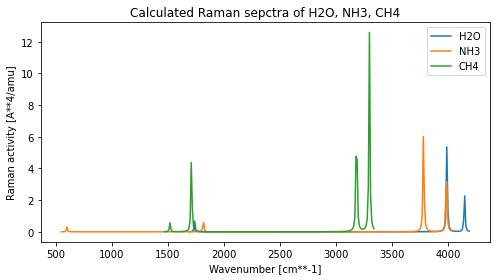

In [10]:
# plot the Raman spectra
plt.figure(figsize=(7,4))

h2o_x,h2o_y = h2o_hessian_drv.frequencies, h2o_hessian_drv.raman_intensities
nh3_x,nh3_y = nh3_hessian_drv.frequencies, nh3_hessian_drv.raman_intensities
ch4_x,ch4_y = ch4_hessian_drv.frequencies, ch4_hessian_drv.raman_intensities

h2o_xl, h2o_yl = add_broadening(h2o_x, h2o_y, line_profile='Lorentzian', line_param=10, step=10)
nh3_xl, nh3_yl = add_broadening(nh3_x, nh3_y, line_profile='Lorentzian', line_param=10, step=10)
ch4_xl, ch4_yl = add_broadening(ch4_x, ch4_y, line_profile='Lorentzian', line_param=10, step=10)

plt.plot(h2o_xl, h2o_yl, label='H2O')
plt.plot(nh3_xl, nh3_yl, label='NH3')
plt.plot(ch4_xl, ch4_yl, label='CH4')

plt.xlabel('Wavenumber (cm**-1)')
plt.ylabel('Raman activity (A**4/amu)')
plt.title("Calculated Raman sepctra of H2O, NH3, CH4")
plt.legend()
plt.tight_layout(); plt.show()

Let's compare the H-stretching modes:

In [11]:
# To animate the normal mode we will need both the geometry and the displacements 
def get_normal_mode(molecule, normal_mode):
    elements = molecule.get_labels()
    coords = molecule.get_coordinates() * bohr_in_angstroms() # To transform from au to A
    natm = molecule.number_of_atoms()
    vib_xyz = "%d\n\n" % natm
    nm = normal_mode.reshape(natm, 3)
    for i in range(natm):
        # add coordinates:
        vib_xyz += elements[i] + " %15.7f %15.7f %15.7f " % (coords[i,0], coords[i,1], coords[i,2])
        # add displacements:
        vib_xyz += "%15.7f %15.7f %15.7f\n" % (nm[i,0], nm[i,1], nm[i,2])
    return vib_xyz

In [12]:
h2o_h1 = get_normal_mode(h2o, h2o_hessian_drv.normal_modes[-2])
h2o_h2 = get_normal_mode(h2o, h2o_hessian_drv.normal_modes[-1])

nh3_h1 = get_normal_mode(nh3, nh3_hessian_drv.normal_modes[-3])
nh3_h2 = get_normal_mode(nh3, nh3_hessian_drv.normal_modes[-2])
nh3_h3 = get_normal_mode(nh3, nh3_hessian_drv.normal_modes[-1])

ch4_h1 = get_normal_mode(ch4, ch4_hessian_drv.normal_modes[-4])
ch4_h2 = get_normal_mode(ch4, ch4_hessian_drv.normal_modes[-3])
ch4_h3 = get_normal_mode(ch4, ch4_hessian_drv.normal_modes[-2])
ch4_h4 = get_normal_mode(ch4, ch4_hessian_drv.normal_modes[-1])

In [13]:
print("These are the two H stretching modes of H2O.")
view = p3d.view(viewergrid=(1,2), width=300, height=200, linked=True)
view.addModel(h2o_h1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,0))
view.addModel(h2o_h2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,1))
view.setStyle({'stick':{}})
view.animate({'loop': 'backAndForth'})
view.rotate(120, "x")
view.zoomTo()
view.show()

These are the two H stretching modes of H2O.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
print("These are the three H stretching modes of NH3.")
view = p3d.view(viewergrid=(1,3), width=600, height=200, linked=True)
view.addModel(nh3_h1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,0))
view.addModel(nh3_h2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,1))
view.addModel(nh3_h3, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,2))
view.setStyle({'stick':{}})
view.animate({'loop': 'backAndForth'})
view.rotate(90, "x")
view.zoomTo()
view.show()

These are the three H stretching modes of NH3.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
print("These are the four H stretching modes of CH4.")
view = p3d.view(viewergrid=(1,4), width=600, height=200, linked=True)
view.addModel(ch4_h1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,0))
view.addModel(ch4_h2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,1))
view.addModel(ch4_h3, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,2))
view.addModel(ch4_h4, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,3))
view.setStyle({'stick':{}})
view.animate({'loop': 'backAndForth'})
view.zoomTo()
view.show()

These are the four H stretching modes of CH4.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol